In [11]:
import math
import numpy as np # 1.24.3
import matplotlib # 3.7.1
import matplotlib.pyplot as plt
import pandas as pd # 1.5.3
import pickle # 0.7.5
from scipy import stats # 1.20.1
import json
import itertools
from copy import deepcopy

This notebook contains code to reproduce figures in "When are two lists better than one?: Benefits and Harms in Joint Decision-making".

In [13]:
def WriteJson(name, data):
   j = json.dumps(data)
   with open(name,'a') as f:
      f.write(j)
      f.write('\n')


seed = 0

def enumerated_product(*args):
    yield from zip(itertools.product(*(range(len(x)) for x in args)), itertools.product(*args))

def kendall_tau(a, b):
  '''
  Helper function for Kenall Tau distance (needed for Mallows model)
  '''
  if not len(a) == len(b):
    print('wrong length')
  P = 0
  Q = 0
  for p in itertools.combinations(a, 2): # for every pair of items
      i = a.index(p[0]) - a.index(p[1]) # negative if 0th ranked before 1st
      j = b.index(p[0]) - b.index(p[1])
      if i*j > 0: # if a and b both agree on relative order of items
          P +=1
      else: # otherwise, inversion
          Q +=1
  return Q

def generate_mallows_rewards(time, nitems, dist, alg_central, human_central, alg_acc, hum_acc):
  '''
  Helper function for sampling from Mallows distribution.

  Args:
    time: total number of time steps
    nitems: total number of items
    dist: distribution (mallows or mallows_anch, for anchored version)
    alg_central, human_central: central distributions for algorithm, human
    alg_acc, hum_acc: algorithm, human accuracy

  Returns:
    list of lists with rewards for all items for all times.
  '''
  all_perms = [list(val) for val in list(itertools.permutations(range(nitems)))]

  # make algorithm distribution
  swap_dist_a = [kendall_tau(alg_central, perm) for perm in all_perms]
  intermediate_a = [np.exp(-alg_acc*val) for val in swap_dist_a]
  alg_probs = intermediate_a/sum(intermediate_a)

  # sample from algorithm distribution
  alg_dist = stats.rv_discrete(name='alg_dist', values=(range(len(all_perms)), alg_probs))
  alg_index = alg_dist.rvs(size = time)
  alg_perms = [all_perms[i] for i in alg_index]

  # translate into rewards for each item
  alg_rewards = (nitems -pd.DataFrame(alg_perms)).values.T.tolist()

  if dist == 'mallows':
    # make human distribution
    swap_dist_h = [kendall_tau(human_central, perm) for perm in all_perms]
    intermediate_h = [np.exp(-hum_acc*val) for val in swap_dist_h]
    hum_probs = intermediate_h/sum(intermediate_h)

    # sample from human distribution
    hum_dist = stats.rv_discrete(name='hum_dist', values=(range(len(all_perms)), hum_probs))
    hum_index = hum_dist.rvs(size = time)
    hum_perms = [all_perms[i] for i in hum_index]

    # translate into rewards for each item
    hum_rewards = (nitems -pd.DataFrame(hum_perms)).values.T.tolist()
  elif dist == 'mallows_anch':
    hum_perms = []
    for i in range(time):
      swap_dist_h = [kendall_tau(alg_perms[i], perm) for perm in all_perms] # human's central is algorithm's value
      intermediate_h = [np.exp(-hum_acc*val) for val in swap_dist_h]
      hum_probs = intermediate_h/sum(intermediate_h)

      hum_dist = stats.rv_discrete(name='hum_dist', values=(range(len(all_perms)), hum_probs))
      hum_index = hum_dist.rvs(size = 1)[0]
      hum_perms.append(all_perms[hum_index])
    # translate into rewards for each item
    hum_rewards = (nitems -pd.DataFrame(hum_perms)).values.T.tolist()
  return alg_rewards, hum_rewards

def generate_rewards_RUM_weight(time, nitems, true_means_alg,
                                true_means_human, cov_mat, weight_alg = None):
  '''
  Function that calculates (partially) anchored RUM rewards with flexible weight parameter
  reflecting influence of algorithm and human. Assumes normal distribution.

  Args:
    time: total number of time steps
    nitems: total number of items
    true_means_alg, true_means_human: list of length nitems, true means of items
    cov_mat: list of lists containing 2 by 2 covariance matrix between algorithm
             and human
    weight_alg: weight to put on algorithm's ordering (in [0, 1]), default 0.5

  Returns:
    list of lists with rewards for all items for all times.

  '''
  if weight_alg == None:
    weight_alg = 0.5

  # algorithm's rewards are i.i.d from normal distributions
  alg_rewards = []
  human_rewards = []
  for i in range(nitems):
    alg_rewards.append(np.random.normal(loc = true_means_alg[i],
                                        scale = np.sqrt(cov_mat[0][0]),
                                        size = time).tolist())
  flipped_rewards = pd.DataFrame(alg_rewards).T.values
  permutations = [sorted(np.random.permutation(list(range(nitems))).tolist(),
                                key = lambda sub:rewards_now_alg[sub],
                         reverse = True) for rewards_now_alg in
                  flipped_rewards]
  # take algorithm's orderings as implied true means for human
  implied_means = [[true_means_alg[i] for i in val] for val in permutations]

  # human's anchored means incorporates human means + anchored means by algorithm
  human_anch_means = (weight_alg * pd.DataFrame(implied_means) +
                      (1-weight_alg)*pd.DataFrame([true_means_human] * time))

  for i in range(nitems):
    # human's rewards are anchored on algorithm
    human_rewards.append([np.random.normal(loc = human_anch_means.iloc[t, i],
                                           scale = np.sqrt(cov_mat[1][1]),
                                    size = 1)[0] for t in range(time)])

  return alg_rewards, human_rewards

def generate_rewards_correlated(time, nitems, true_means_alg = [0.1, 0.05],
                                true_means_human = [0.1, 0.05],
                                cov_mat = [[0.1, 0], [0, 0.1]], dist = 'norm',
                                alg_central = None, human_central = None,
                                alg_acc = 1, hum_acc = 1, weight_alg = None):
  '''
  Generates rewards for each of the items, given potential anchoring between
  human and algorithm.

  Args:
    time: total number of time steps
    nitems: total number of items
    true_means_alg, true_means_human: list of length 2 or nitems, true means of
                                      best item and other items
    cov_mat: list of lists containing 2 by 2 covariance matrix between algorithm
             and human
             for different items?
    dist: 'norm', 'laplace' for RUM with normal, laplace distributions,
          'mallows', 'mallows_anch' for mallows without and with anchoring
    alg_acc, hum_acc: Mallows accuracy for alg, human
    weight_alg: weight to place on algorithm in RUM anchored.

  Returns:
    list of lists with rewards for all items for all times.
  '''
  alg_rewards = []
  human_rewards = []

  # translate from len 2 notation to len nitems notation
  if len(true_means_alg) < nitems:
    true_means_alg = [true_means_alg[0]] + [true_means_alg[1]] * (nitems - 1)
    true_means_human = [true_means_human[0]] + [true_means_human[1]]*(nitems - 1)

  if dist== 'mallows' or dist == 'mallows_anch':
    if alg_central == None:
      alg_central = range(nitems)
    if human_central == None:
      human_central = range(nitems)
    alg_rewards, human_rewards = generate_mallows_rewards(time = time,
                                                          nitems = nitems,
                                                          dist = dist,
                                                          alg_central = alg_central,
                                                          human_central = human_central,
                                                          alg_acc = alg_acc,
                                                          hum_acc = hum_acc
                                                          )
  elif dist == 'norm_anch':
    alg_rewards, human_rewards = generate_rewards_RUM_weight(time = time,
                                                             nitems = nitems,
                                                             true_means_alg = true_means_alg,
                                                             true_means_human = true_means_human,
                                                             cov_mat = cov_mat,
                                                             weight_alg = weight_alg

    )

  else:
    for i in range(nitems):
      if dist == 'norm':
        item_rewards = np.random.multivariate_normal(mean = [true_means_alg[i],
                                                            true_means_human[i]],
                                                    cov = cov_mat, size = time)
      elif dist == 'laplace':
        alg_rewards  = np.random.laplace(loc = true_means_alg[i],
                                             scale = np.sqrt(cov_mat[0][0]/2),
                                             size = time)
        hum_rewards =  np.random.laplace(loc = true_means_human[i],
                                        scale = np.sqrt(cov_mat[1][1]/2),
                                        size = time)
        item_rewards = np.array([alg_rewards, hum_rewards]).T


      alg_rewards.append(item_rewards.T[0].tolist())
      human_rewards.append(item_rewards.T[1].tolist())
  return alg_rewards, human_rewards

def human_best(rewards, presented, epsilon = 0, ignore_presented = False):
  '''
  Selects the best item after seeing current rewards.

  Args:
    rewards: list of rewards for items in this time period
    presented: list of indices of selected items (by alg)
    epsilon: what probability to select randomly
    ignore_presented: if true, ignore the presented items and pick from all sets
                      of items.

  Returns:
    index of selected item
  '''
  n = len(rewards)
  if ignore_presented: # if we ignore presented, human looks at all items
    presented = list(range(n))
  if np.random.uniform() < epsilon:
    selected = np.random.choice(presented) # randomly explore w/prob epsilon
  else:
    # greedily take highest current reward, break ties randomly
    selected = sorted(np.random.permutation(presented).tolist(),
                      key = lambda sub:rewards[sub], reverse = True)[0]
  return selected

def main(rewards_alg_list, rewards_human_list, time=1000, nitems=5, kpresent=2, nsims = 10,
         kwargs = {'epsilon': 0}):
  '''
  Simulates human algorithm system jointly.

  Args:
    rewards_alg_list: list of lists of rewards for algorithm
    rewards_human_list: list of lists of rewards for human
    time: number of time steps
    nitems: number of items
    kpresent: number of items presented to the human
    kwargs: dictionary of parameters for human selection function
    nsims: number of simulations

  Returns:
    list of lists of which item selected for each simulation
  '''
  selected_list_list = []

  for it in range(nsims): # number of simulations
    # ubc with human
    selected_list = [] # list of which item selected each round
    rewards_alg = rewards_alg_list[it]
    rewards_human = rewards_human_list[it]
    n = len(rewards_alg)
    for t in range(time):
     rewards_now_alg = [rewards_alg[i][t] for i in range(n)]
     best_indices = sorted(np.random.permutation(list(range(n))).tolist(),
                          key = lambda sub:rewards_now_alg[sub], reverse = True)[:kpresent]
     selected = human_best(rewards = [rewards_human[i][t] for i in range(n)],
                           presented = best_indices, **kwargs)

     selected_list.append(selected)
    selected_list_list.append(selected_list)
  return selected_list_list

In [14]:
my_path = '/save_files/' # update this to your path

Below is code to reproduce Figure 1 (showing performance of RUM model with varying degrees of anchoring).

1
2
3
4
5


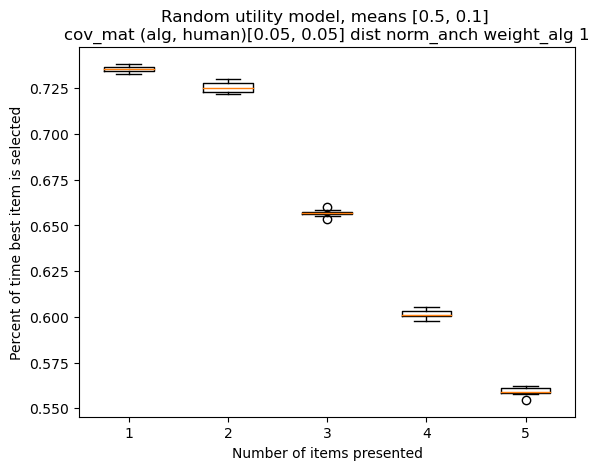

1
2
3
4
5


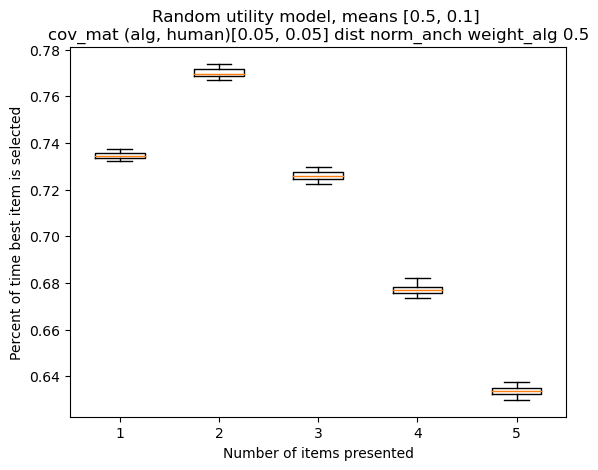

1
2
3
4
5


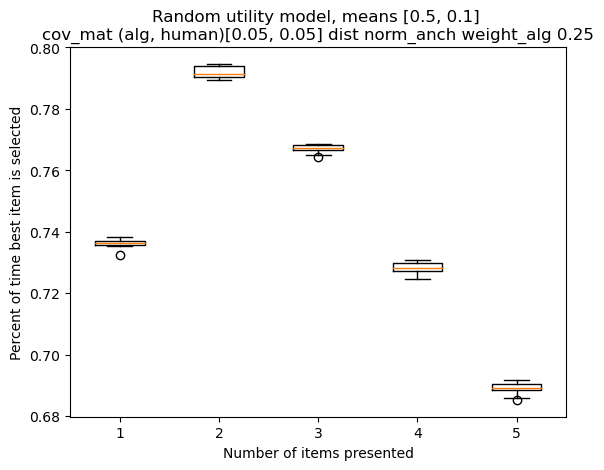

1
2
3
4
5


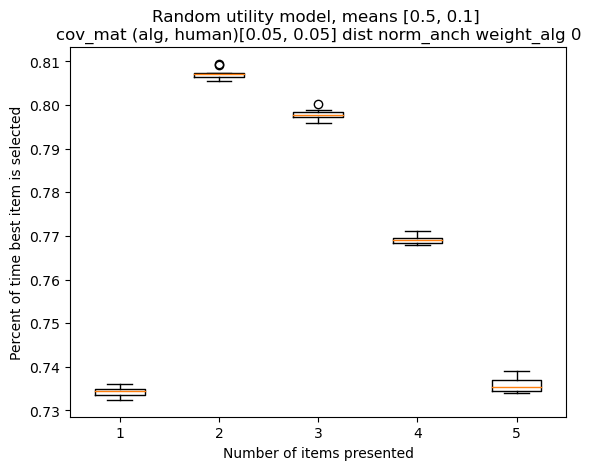

In [5]:
nsimval = 10
time_val = 5*10**4
nitems = 5
cov_val = 0.0
baditem = 0.1
alg_cov = 0.05
hum_cov = 0.05
alg_acc = 1
hum_acc = 1
params = {
    'dist': ['norm_anch'],
    'weight_alg': [1, 0.5, 0.25, 0]
}
keys = list(params)
itemrange = range(1, nitems+1) # consider all possible set of items presented
for values in itertools.product(*map(params.get, keys)):
  dist = dict(zip(keys, values))['dist']
  weight_alg = dict(zip(keys, values))['weight_alg']
  true_means_val_alg = [0.5] + [baditem] * (nitems-1)
  true_means_val_human = true_means_val_alg.copy()
  cov_mat = [[alg_cov, cov_val], [cov_val, hum_cov]]

  rewards_alg_list = []
  rewards_human_list = []
  for _ in range(nsimval):
    corr_rewards = generate_rewards_correlated(time_val, nitems, true_means_alg = true_means_val_alg,
                                             true_means_human = true_means_val_human, cov_mat = cov_mat,
                                             dist = dist, alg_acc = alg_acc,
                                             hum_acc = hum_acc, weight_alg = weight_alg)
    rewards_alg_list.append(corr_rewards[0])
    rewards_human_list.append(corr_rewards[1])

  dataname = np.random.randint(1, 10000)
  file = open(my_path + 'reward_store_RUM' + str(dataname), 'wb')
  pickle.dump([rewards_alg_list, rewards_human_list], file)
  file.close()
  results_dict = {'dataname': dataname, 'time': time_val, 'true_means_alg': true_means_val_alg, 'true_means_human': true_means_val_human, "nitems": nitems,
                  "nsimval": nsimval, "cov_mat": cov_mat, "dist": dist, 'alg_acc': alg_acc,
                  'hum_acc': hum_acc, 'weight_alg': weight_alg}
  WriteJson(my_path +'reward_store_RUM.json', results_dict)
  results_list = []
  for i in itemrange:
      print(i)
      results_list.append(main(rewards_alg_list, rewards_human_list, time=time_val, nitems=nitems, kpresent=i, nsims = nsimval,
          kwargs = {'epsilon': 0}))

  prop_best = [[(pd.DataFrame(results_list[k-1][isim]) == 0).mean()[0] for isim in range(nsimval)] for k in itemrange]
  plt.boxplot(prop_best)
  plt.xlabel('Number of items presented')
  plt.ylabel('Percent of time best item is selected')
  if dist in ['mallows', 'mallows_anch']:
    plt.title('Mallows model, accuracies (alg, human) ' + str((alg_acc, hum_acc)) + ' dist ' + str(dist))
  else:
    plt.title('Random utility model, means ' + str(true_means_val_alg[0:2]) + ' \ncov_mat (alg, human)'
              + str([cov_mat[0][0], cov_mat[1][1]]) + ' dist ' + dist+ ' weight_alg ' + str(weight_alg))
  simname = np.random.randint(1, 10000) # adding in storing the data

  plt.savefig(my_path +'plot_' + str(dataname)+ '_' + str(simname) + '.png')
  plt.show()

  file = open(my_path + 'data_RUM' + str(dataname)+ '_' + str(simname)  , 'wb')
  pickle.dump(results_list, file)
  file.close()

  results_dict = {'dataname': dataname, 'time': time_val, 'true_means_alg': true_means_val_alg, 'true_means_human': true_means_val_human, "nitems": nitems,
                  "nsimval": nsimval, "cov_mat": cov_mat, "dist": dist, 'alg_acc': alg_acc,
                  'hum_acc': hum_acc, 'weight_alg': weight_alg}
  WriteJson(my_path + 'data_store_RUM.json', results_dict)

Code to replicate Figure 3 (note: takes multiple hours to run).

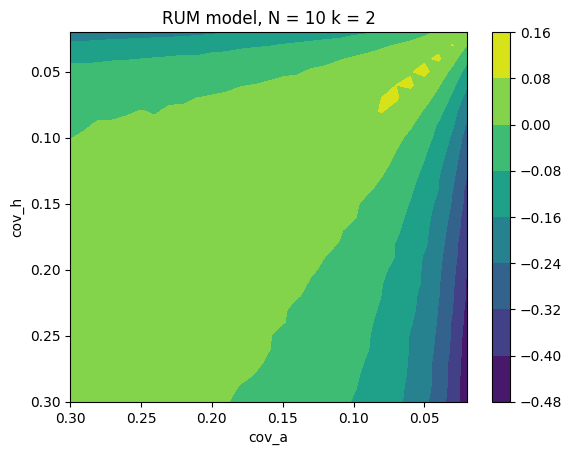

In [ ]:
nsimval = 1
time_val = 5*10**4
nitems = 10
dist = 'norm'
cov_val = 0.0
baditem = 0.1
alg_acc = 1
hum_acc = 1
weight_alg = 0
alg_acc_range = np.arange(0.3, 0.01, -0.01)  # accuracy range to explore
hum_acc_range = alg_acc_range.copy()
kval = 2
alg_acc_frame = pd.DataFrame(index = range(len(hum_acc_range)),
                             columns = range(len(alg_acc_range)))
hum_acc_frame = alg_acc_frame.copy()
joint_acc_frame = alg_acc_frame.copy()

simname = np.random.randint(1, 10000) # adding in storing the data
for idx, values in enumerated_product(hum_acc_range, alg_acc_range):
  alg_cov = values[1]
  hum_cov = values[0]
  true_means_val_alg = [0.5] + [baditem] * (nitems-1)
  true_means_val_human = true_means_val_alg.copy()
  cov_mat = [[alg_cov, cov_val], [cov_val, hum_cov]]

  rewards_alg_list = []
  rewards_human_list = []
  for _ in range(nsimval):
    corr_rewards = generate_rewards_correlated(time_val, nitems,
                                               true_means_alg = true_means_val_alg,
                                               true_means_human = true_means_val_human,
                                               cov_mat = cov_mat,
                                               dist = dist, alg_acc = alg_acc,
                                               hum_acc = hum_acc,
                                               weight_alg = weight_alg)
    rewards_alg_list.append(corr_rewards[0])
    rewards_human_list.append(corr_rewards[1])

  dataname = np.random.randint(1, 10000)
  file = open(my_path + 'reward_store_RUM' + str(dataname), 'wb')
  pickle.dump([rewards_alg_list, rewards_human_list], file)
  file.close()
  results_dict = {'dataname': dataname, 'time': time_val, 'true_means_alg': true_means_val_alg,
                  'true_means_human': true_means_val_human, "nitems": nitems,
                  "nsimval": nsimval, "cov_mat": cov_mat, "dist": dist, 'alg_acc': alg_acc,
                  'hum_acc': hum_acc, 'weight_alg': weight_alg}
  WriteJson(my_path +'reward_store_RUM.json', results_dict)
  results_list = []

  # calculate joint and separate accuracy rates
  joint_perf = main(rewards_alg_list, rewards_human_list, time=time_val, nitems=nitems, kpresent=kval, nsims = nsimval,
          kwargs = {'epsilon': 0})
  joint_acc_frame.iloc[idx] = [(pd.DataFrame(joint_perf[isim]) == 0).mean()[0] for isim in range(nsimval)][0] # reward of joint system
  alg_perf = main(rewards_alg_list, rewards_human_list, time=time_val, nitems=nitems, kpresent=1, nsims = nsimval,
          kwargs = {'epsilon': 0})
  alg_acc_frame.iloc[idx] = [(pd.DataFrame(alg_perf[isim]) == 0).mean()[0] for isim in range(nsimval)][0] # reward of alg alone
  hum_perf = main(rewards_alg_list, rewards_human_list, time=time_val, nitems=nitems, kpresent=nitems, nsims = nsimval,
          kwargs = {'epsilon': 0})
  hum_acc_frame.iloc[idx] = [(pd.DataFrame(hum_perf[isim]) == 0).mean()[0] for isim in range(nsimval)][0] # reward of human alone

file = open(my_path + 'acc_frame' + str(simname), 'wb')
pickle.dump([joint_acc_frame, alg_acc_frame,  hum_acc_frame], file)
file.close()

results_dict = {'simname': simname, 'time': time_val, 'true_means_alg': true_means_val_alg, 'true_means_human': true_means_val_human, "nitems": nitems,
                  "nsimval": nsimval, "cov_mat": cov_mat, "dist": dist, 'alg_acc_range': alg_acc_range.tolist(),
                  'hum_acc_range': hum_acc_range.tolist(), 'weight_alg': weight_alg}
WriteJson(my_path + 'data_store_RUM_grid.json', results_dict)

x = hum_acc_range
y = alg_acc_range
X, Y = np.meshgrid(x, y)
diff_frame = joint_acc_frame - np.maximum(alg_acc_frame, hum_acc_frame)

fig, ax = plt.subplots()
cs = ax.contourf(X, Y, np.array(diff_frame.T.values, dtype=float))
cbar = fig.colorbar(cs)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel('cov_a')
plt.ylabel('cov_h')
plt.title('RUM model, N = ' + str(nitems) + ' k = ' + str(kval))
plt.savefig(my_path +'plot_' + str(simname) + '.png')
plt.show()